**Required Libraries**

In [18]:
from collections import defaultdict

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Constant definitions**

In [19]:
DATA_DIR = "./data/images"
ANNOT_DIR = "./data/annotations"

**Utility Functions**

In [20]:
def clamp(value, minimum, maximum):
    return min(maximum, max(minimum, value))

In [21]:
def display_bgr_image(bgr_image, show=True):
    rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(rgb_image)
    ax.axis(False)
    if show:
        plt.show()
    return fig, ax

def display_gray_image(gray_image, show=True):
    fig, ax = plt.subplots()
    ax.imshow(gray_image, cmap="gray")
    ax.axis(False)
    if show:
        plt.show()
    return fig, ax

In [22]:
def weighted_gray_transform(bgr_image, weights=[0.114, 0.587, 0.299]):
    m = np.array(weights).reshape((1,3))
    return cv.transform(bgr_image, m)

# Original Image

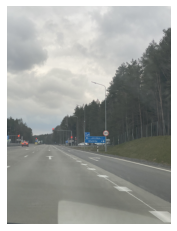

<Figure size 432x288 with 0 Axes>

In [23]:
selected_image = 239
src_image = cv.imread(f"{DATA_DIR}/road{selected_image}.png")

fig, ax = display_bgr_image(src_image)
plt.clf();

# Image Processing
In this phase, the image will be treated in an attempt to reduce possible noise from environment and/or weather, this will be achieved by applying **CLAHE equalization** on the image, followed by an **automatic brightness and contrast correction** and finishing with the initial step of **meanShift**, this is the filtering stage of the **meanshift** segmentation that flattens color gradients and fine-grain textures of the image (see `pyrMeanShiftFiltering`).

## Attenuating bright sky blue lighting

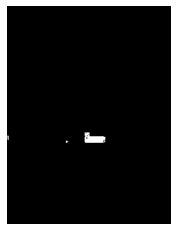

Maximum B pixels = 0.2143
Sky ratio = 0.004325


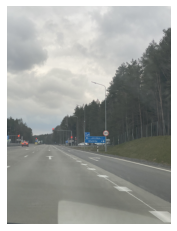

<Figure size 432x288 with 0 Axes>

In [24]:
def segment_sky(bgr_image):
    hsv_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)

    # Light blue sky zone
    lowerbound = np.array([85, 60, 130])
    upperbound = np.array([108, 255, 255])

    mask = cv.inRange(hsv_image, lowerbound, upperbound)
    
    segmented_image = cv.bitwise_and(bgr_image, bgr_image, mask=mask)
    BIN_THRESHOLD = 0.5

    gray_image = cv.cvtColor(segmented_image, cv.COLOR_BGR2GRAY)

    threshold = int(255 * BIN_THRESHOLD)
    ret_thresh, gray_image = cv.threshold(gray_image, threshold, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return gray_image

def attenuate_sky_light(bgr_image):
    max_pixels = np.argmax(bgr_image, axis=2)
    max_blue_pixels = max_pixels[max_pixels == 0].size

    sky_image = segment_sky(bgr_image)
    sky_pixels = sky_image[sky_image > 127].size
    total_pixels = sky_image.size
    max_blue_ratio = float(max_blue_pixels) / total_pixels
    sky_ratio = float(sky_pixels) / total_pixels

    display_gray_image(sky_image)

    print(f"Maximum B pixels = {max_blue_ratio}")
    print(f"Sky ratio = {sky_ratio}")
    SKY_THRESHOLD = 0.40
    MAX_BLUE_THRESHOLD = 0.85
    if sky_ratio > SKY_THRESHOLD and max_blue_ratio > MAX_BLUE_THRESHOLD:
        B, G, R = cv.split(bgr_image)
        return cv.merge([cv.equalizeHist(B), cv.equalizeHist(G), cv.equalizeHist(R)])
    else:
        return bgr_image

attenuated_image = attenuate_sky_light(src_image)
display_bgr_image(attenuated_image)
plt.clf();

## CLAHE Equalization

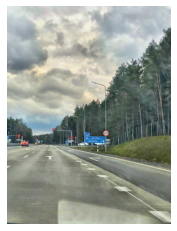

<Figure size 432x288 with 0 Axes>

In [25]:
def hsv_clahe_equalization(bgr_image, clipLimit = 2.0, tileGridSize = (8, 8)):
    hsv_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)

    h, s, v = cv.split(hsv_image)

    clahe = cv.createCLAHE(
        clipLimit=clipLimit,
        tileGridSize=tileGridSize
    )

    s_equalized = clahe.apply(s)
    v_equalized = clahe.apply(v)

    equalized_image = cv.merge([h, s_equalized, v_equalized])
    return cv.cvtColor(equalized_image, cv.COLOR_HSV2BGR)

clahe_image = hsv_clahe_equalization(attenuated_image, clipLimit=3.0, tileGridSize=(15, 15))
fig, ax = display_bgr_image(clahe_image)
plt.clf();

## Automatic Brightness and Contrast Correction

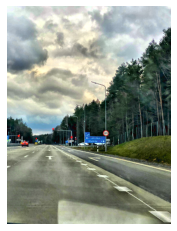

<Figure size 432x288 with 0 Axes>

In [26]:
def automatic_brightness_contrast(bgr_image, clip_hist_percent = 0.01, use_scale_abs = True, return_verbose = False):
    gray_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2GRAY)

    # Grayscale histogram of the image
    hist = cv.calcHist([gray_image], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Cumulative distribution of the histogram
    acc = []
    acc.append( float(hist[0]) )
    for i in range(1, hist_size):
        acc.append( acc[i - 1] + float(hist[i]) )
    
    # Locate points to clip
    maximum = acc[-1]
    clip_hist = clip_hist_percent * maximum / 2.0

    # Left cut
    minimum_gray = 0
    while acc[minimum_gray] < clip_hist:
        minimum_gray += 1

    # Right cut
    maximum_gray = hist_size - 1
    while acc[maximum_gray] >= (maximum - clip_hist):
        maximum_gray -= 1

    # Calculate alpha and beta values for the scaling
    alpha = 255 / (maximum_gray - minimum_gray + 1e-6)
    beta = - minimum_gray * alpha

    if use_scale_abs:
        processed_image = cv.convertScaleAbs(bgr_image, alpha=alpha, beta=beta)
    else:
        processed_image = np.uint8(np.abs(bgr_image * alpha + beta))
        processed_image = np.clip(processed_image, 0, 255)

    if return_verbose:
        processed_hist = cv.calcHist([gray_image], [0], None, [256], [minimum_gray, maximum_gray])

        return processed_image, alpha, beta, hist, processed_hist
    
    return processed_image

contrast_image = automatic_brightness_contrast(clahe_image, clip_hist_percent=0.01, use_scale_abs=True)
fig, ax = display_bgr_image(contrast_image)
plt.clf();


## Mean Shift Filtering

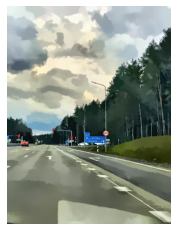

<Figure size 432x288 with 0 Axes>

In [27]:
processed_image = cv.pyrMeanShiftFiltering(contrast_image, 10, 25, 100)
fig, ax = display_bgr_image(processed_image)
plt.clf();

# Color Segmentation

In this phase, the processed image will be segmented by color. It was decided to segment the reds and blues separately. Afterwards, the segmented image is binarized by application of thresholding techniques, in this case, it was decided to use Otsu technique for thresholding. Further more, it is done a small post-processing to remove small components of the image that aren't likely to be traffic signs.

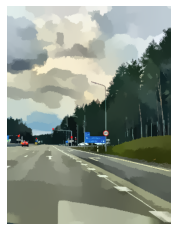

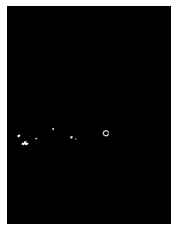

---------------


<Figure size 432x288 with 0 Axes>

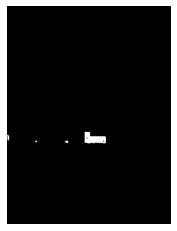

---------------


<Figure size 432x288 with 0 Axes>

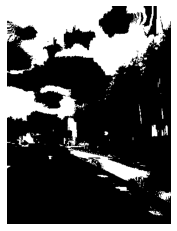

<Figure size 432x288 with 0 Axes>

In [28]:
def segment(bgr_image):
    smooth_image = cv.edgePreservingFilter(bgr_image, flags=cv.NORMCONV_FILTER, sigma_s=50, sigma_r=0.25)
    B, G, R = cv.split(smooth_image)
    display_bgr_image(smooth_image)
    hsv_image = cv.cvtColor(smooth_image, cv.COLOR_BGR2HSV)    
    H, S, V = cv.split(hsv_image)

    B, G, R = np.float64(B) / 255.0, np.float64(G) / 255.0, np.float64(R) / 255.0
    H, S, V = np.float64(H) / 179.0 * 360.0, np.float64(S) / 255.0, np.float64(V) / 255.0

    M, N, _ = smooth_image.shape
    hd_blue = np.zeros(shape=(M, N), dtype=np.float64)
    hd_red = np.zeros(shape=(M, N), dtype=np.float64)
    hd_white_black = np.zeros(shape=(M, N), dtype=np.float64)
    
    RED_TH_1 = 25
    RED_TH_2 = 315
    RED_S_TH = 0.35
    RED_V_TH = 0.10

    BLUE_TH_L = 200
    BLUE_TH_H = 255
    BLUE_S_TH = 0.45
    BLUE_V_TH = 0.15

    WHITE_S_TH = 0.1
    BLACK_V_TH = 0.1

    hd_red[(H <= RED_TH_1) & (S >= RED_S_TH) & (V >= RED_V_TH)] = 1.0
    hd_red[(H >= RED_TH_2) & (S >= RED_S_TH) & (V >= RED_V_TH)] = 1.0

    hd_blue[(H >= BLUE_TH_L) & (H <= BLUE_TH_H) & (S >= BLUE_S_TH) & (V >= BLUE_V_TH)] = 1.0

    hd_white_black[(S <= WHITE_S_TH) | (V <= BLACK_V_TH)] = 1.0

    hs_red = np.uint8(hd_red * 255)
    hs_blue = np.uint8(hd_blue * 255)
    hs_white_black = np.uint8(hd_white_black * 255)

    return hs_red, hs_blue, hs_white_black

# red_segmented_image_2, blue_segmented_image_2 = segment_2(processed_image)
red_segmented_image, blue_segmented_image, white_black_segmented_image = segment(processed_image)
display_gray_image(red_segmented_image)
plt.clf();
print("---------------")
display_gray_image(blue_segmented_image)
plt.clf();
print("---------------")
display_gray_image(white_black_segmented_image)
plt.clf();

## Post-segmentation Cleanup

Rethink the `removeSmallComponents`

# RoI Extraction

In this phase, it will be extracted the regions of interest (RoI) of the segmented images, those will be considered the potential traffic signs for the next phase. To do this extraction, it will be applied an edge detector followed by extracting the contours and then the bounding rectangle of that contour as the RoI.

## Edge Detection

Edges of Red Segmented Image


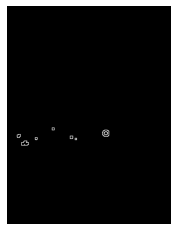

Edges of Blue Segmented Image


<Figure size 432x288 with 0 Axes>

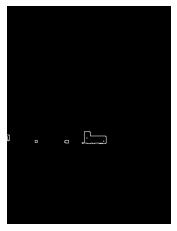

<Figure size 432x288 with 0 Axes>

In [29]:
def edge_detection(gray_image):
    # Apply morphological operation to soften possible artefacts
    # kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize=(3, 3))
    # morph_image = cv.morphologyEx(gray_image, cv.MORPH_CLOSE, kernel, iterations=1)
    morph_image = gray_image.copy()

    #return cv.Canny(morph_image, threshold1=100, threshold2=200, apertureSize=5)
    return cv.adaptiveThreshold(morph_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 3, 10)

    

red_edges = edge_detection(red_segmented_image)
print("Edges of Red Segmented Image")
fig, ax = display_gray_image(red_edges)
plt.clf();

blue_edges = edge_detection(blue_segmented_image)
print("Edges of Blue Segmented Image")
fig, ax = display_gray_image(blue_edges)
plt.clf();


## Extract RoI

Regions of interest will be bounding rectangles of the contours detected in the image processed by Canny edge detector. To eliminate redundant RoI and false positives, RoI that are contained completely inside another will be merged, and RoI which don't meet certain criteria will also be discarded.

Red Regions of Interest


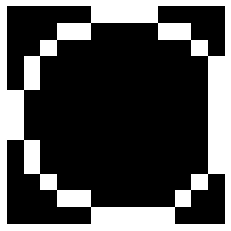

<Figure size 432x288 with 0 Axes>

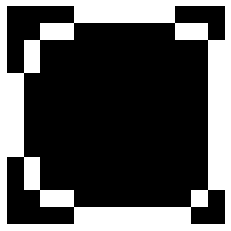

Edge image with bounding boxes and contours


<Figure size 432x288 with 0 Axes>

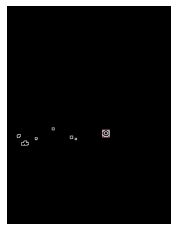

<Figure size 432x288 with 0 Axes>

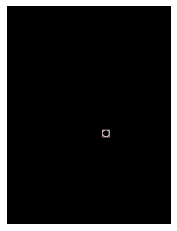

Blue Regions of Interest


<Figure size 432x288 with 0 Axes>

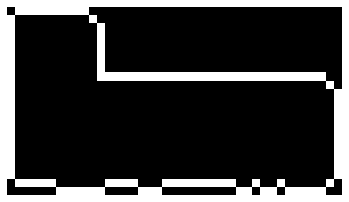

<Figure size 432x288 with 0 Axes>

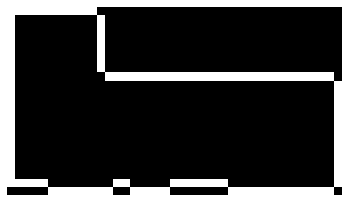

Edge image with bounding boxes and contours


<Figure size 432x288 with 0 Axes>

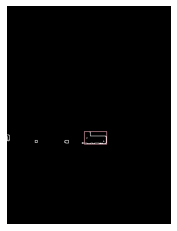

<Figure size 432x288 with 0 Axes>

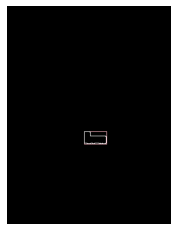

<Figure size 432x288 with 0 Axes>

In [30]:
def mergeROI(rois):
    # Sort RoI by X-coordinate and width to merge RoI
    sorted_rois = sorted(rois, key=lambda roi: (roi[0][0], -roi[0][2], roi[0][1], -roi[0][3]))

    i = 0
    while True:
        if i >= len(sorted_rois):
            break

        pivot = sorted_rois[i]
        pivot_x0, pivot_y0, pivot_x1, pivot_y1 = pivot[0][0], pivot[0][1], pivot[0][0] + pivot[0][2], pivot[0][1] + pivot[0][3]
        j = i + 1
        while True:
            if j >= len(sorted_rois):
                break

            other = sorted_rois[j]
            other_x0, other_y0, other_x1, other_y1 = other[0][0], other[0][1], other[0][0] + other[0][2], other[0][1] + other[0][3]
        
            # Beginning of other RoI is already past the ending of the pivot RoI
            if other_x0 > pivot_x1:
                break

            # Check if it's inside, and delete if so, otherwise advance
            if other_y0 > pivot_y0 and other_y1 < pivot_y1 and other_x1 < pivot_x1:
                sorted_rois.pop(j)
            else:
                j += 1
        
        i += 1
    return sorted_rois


def extractROI(edge_image, red_image, blue_image, white_black_image, roi_type):
    # kernel = cv.getStructuringElement(shape=cv.MORPH_ELLIPSE, ksize=(3, 3))
    # morph_image = cv.morphologyEx(edge_image, cv.MORPH_DILATE, kernel, iterations=1)
    morph_image = edge_image.copy()
    contours, hierarchy = cv.findContours(morph_image, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

    # Apply convex hulls to close off shapes
    # contours = [cv.convexHull(contour) for contour in contours]

    # Approximate contour
    contours = [cv.approxPolyDP(contour, 0.004 * cv.arcLength(contour, True), True) for contour in contours]

    rois = [(cv.boundingRect(contour), contour) for contour in contours]

    i = 0
    while True:
        if i >= len(rois):
            break

        (x, y, w, h), contours = rois[i]
        roi_size = w * h

        SIZE_THRESHOLD = 10 * 10
        if roi_size < SIZE_THRESHOLD:
            rois.pop(i)
            continue

        # contourArea = cv.contourArea(contours)
        # contourPerimeter = cv.arcLength(contours, True)
        # if contourArea < contourPerimeter:
        #     rois.pop(i)
        #     continue

        BIG_SIGN = 50 * 50
        aspect_ratio = float(w) / (h + 1e-6)
        if roi_type == "red":
            if roi_size < BIG_SIGN:
                ASPECT_RATIO_MIN = 0.6
                ASPECT_RATIO_MAX = 1.4
                if aspect_ratio < ASPECT_RATIO_MIN or aspect_ratio > ASPECT_RATIO_MAX: 
                    rois.pop(i)
                    continue
            else:
                ASPECT_RATIO_MIN = 0.45
                ASPECT_RATIO_MAX = 1.55
                if aspect_ratio < ASPECT_RATIO_MIN or aspect_ratio > ASPECT_RATIO_MAX: 
                    rois.pop(i)
                    continue
        elif roi_type == "blue":
            if roi_size < BIG_SIGN:
                ASPECT_RATIO_MIN = 0.7
                ASPECT_RATIO_MAX = 3.5
                if aspect_ratio < ASPECT_RATIO_MIN or aspect_ratio > ASPECT_RATIO_MAX:
                    rois.pop(i)
                    continue
            else:
                ASPECT_RATIO_MIN = 0.45
                ASPECT_RATIO_MAX = 3.0
                if aspect_ratio < ASPECT_RATIO_MIN or aspect_ratio > ASPECT_RATIO_MAX: 
                    rois.pop(i)
                    continue

        blue_pixels = 0
        red_pixels = 0
        white_black_pixels = 0
        contourArea = 0
        for xi in range(x, x+w):
            for yi in range(y, y+h):
                if cv.pointPolygonTest(contours, (xi, yi), measureDist=False) >= 0:
                    if red_image[yi, xi] > 127:
                        red_pixels += 1
                    if blue_image[yi, xi] > 127:
                        blue_pixels += 1
                    if white_black_image[yi, xi] > 127:
                        white_black_pixels += 1 
                    contourArea += 1

        blue_ratio = blue_pixels / (roi_size + 1e-6)
        red_ratio = red_pixels / (roi_size + 1e-6)
        white_black_ratio = white_black_pixels / (roi_size + 1e-6)
        red_blue_ratio = red_pixels / (blue_pixels + 1e-6)

        if roi_type == "red":
            if red_ratio < 0.10:
                rois.pop(i)
                continue
        elif roi_type == "blue":
            if blue_ratio < 0.3:
                rois.pop(i)
                continue
        rois[i] = ((x, y, w, h), contours, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea)

        i += 1
    
    rois = mergeROI(rois)
    
    return rois

red_roi = extractROI(red_edges, red_image=red_segmented_image, blue_image=blue_segmented_image, white_black_image=white_black_segmented_image, roi_type="red")

blue_roi = extractROI(blue_edges, red_image=red_segmented_image, blue_image=blue_segmented_image, white_black_image=white_black_segmented_image, roi_type="blue")

roi_red_image = np.zeros(shape=(red_edges.shape + (3,)), dtype=np.uint8)
brect_roi_red_image = cv.cvtColor(red_edges.copy(), cv.COLOR_GRAY2BGR)
print("Red Regions of Interest")
for roi in red_roi:
    (x, y, w, h), contours, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea = roi
    cv.rectangle(brect_roi_red_image, (int(x), int(y)), (int(x+w), int(y+h)), (197, 183, 255), 1)

    cv.rectangle(roi_red_image, (int(x), int(y)), (int(x+w), int(y+h)), (197, 183, 255), 1)
    cv.drawContours(roi_red_image, [contours], 0, color=(255, 255, 255))
    region = np.zeros_like(red_edges[y:y+h, x:x+w])
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))

    fig, ax = display_gray_image(region)
    plt.clf();

print("Edge image with bounding boxes and contours")
display_bgr_image(brect_roi_red_image)
plt.clf();
display_bgr_image(roi_red_image)
plt.clf();

print("Blue Regions of Interest")
roi_blue_image = np.zeros(shape=(blue_edges.shape + (3,)), dtype=np.uint8)
brect_roi_blue_image = cv.cvtColor(blue_edges.copy(), cv.COLOR_GRAY2BGR)
for roi in blue_roi:
    (x, y, w, h), contours, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea = roi
    cv.rectangle(brect_roi_blue_image, (int(x), int(y)), (int(x+w), int(y+h)), (197, 183, 255), 1)

    cv.rectangle(roi_blue_image, (int(x), int(y)), (int(x+w), int(y+h)), (197, 183, 255), 1)
    cv.drawContours(roi_blue_image, [contours], 0, color=(255, 255, 255))
    region = np.zeros_like(blue_edges[y:y+h, x:x+w])
    # for x0 in range(x, x+w):
    #     for y0 in range(y, y+h):
    #         if cv.pointPolygonTest(contours, (x0, y0), measureDist=False) >= 0:
    #             region[y0-y, x0-x] = 255

    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))
    fig, ax = display_gray_image(region)
    plt.clf();

print("Edge image with bounding boxes and contours")
display_bgr_image(brect_roi_blue_image)
plt.clf();
display_bgr_image(roi_blue_image)
plt.clf();

# Shape Detection

## Corner Detection

Corner detection on reds
TL: 0.25 | TC: 0.25 |  TR: 0.25 |  ML: 0.25 |  MR: 0.25 |  BL: 0.25 |  BC: 0.25 |  BR: 0.25
Square: 0.5 | Triangle Up: 0.0 | Triangle Down: 0.0 | Circle: 1.0


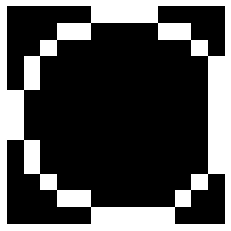

<Figure size 432x288 with 0 Axes>

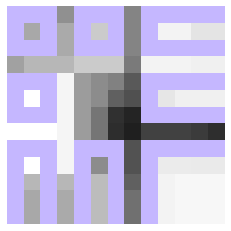

TL: 0.25 | TC: 0.25 |  TR: 0.25 |  ML: 0.25 |  MR: 0.25 |  BL: 0.25 |  BC: 0.25 |  BR: 0.25
Square: 0.5 | Triangle Up: 0.0 | Triangle Down: 0.0 | Circle: 1.0


<Figure size 432x288 with 0 Axes>

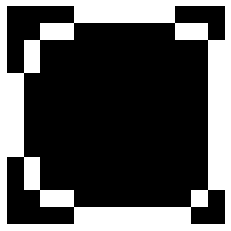

<Figure size 432x288 with 0 Axes>

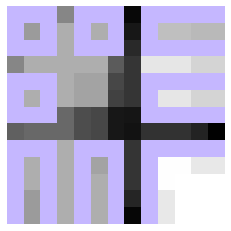

Corner detection on blues
TL: 0.25 | TC: 0.0 |  TR: 0.0 |  ML: 0.0 |  MR: 0.25 |  BL: 0.25 |  BC: 0.0 |  BR: 0.25
Square: 0.625 | Triangle Up: 0.20833333333333337 | Triangle Down: 0.0 | Circle: 0.4


<Figure size 432x288 with 0 Axes>

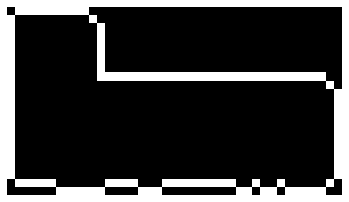

<Figure size 432x288 with 0 Axes>

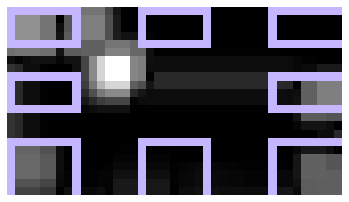

TL: 0.25 | TC: 0.0 |  TR: 0.0 |  ML: 0.0 |  MR: 0.25 |  BL: 0.25 |  BC: 0.0 |  BR: 0.25
Square: 0.625 | Triangle Up: 0.20833333333333337 | Triangle Down: 0.0 | Circle: 0.4


<Figure size 432x288 with 0 Axes>

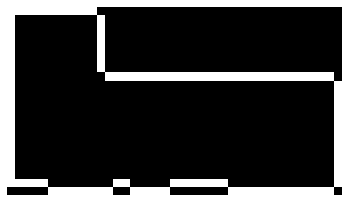

<Figure size 432x288 with 0 Axes>

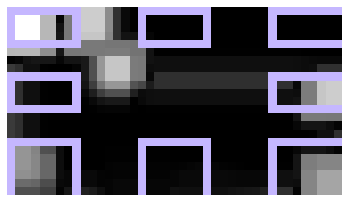

<Figure size 432x288 with 0 Axes>

In [31]:
def corner_detection(roi):
    (x, y, w, h), contours, _, _, _, _, _ = roi
    region = np.zeros(shape=(h, w), dtype=np.uint8)
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))
    region_32f = np.float32(region)

    corners = cv.cornerHarris(region_32f, 6, 5, 0.06)
    corners = cv.dilate(corners, None)

    norm_corners = np.empty(corners.shape, dtype=np.float32)
    cv.normalize(corners, norm_corners, 255.0, 0.0, cv.NORM_INF)
    norm_corners = cv.convertScaleAbs(norm_corners)

    CORNER_THRESHOLD = 75

    ND = 5
    P = 1.0 / ND
    dw, dh = int(P * w), int(P * h)

    tl = 0.25 * (norm_corners[0:dh, 0:dw].max() > CORNER_THRESHOLD)
    tc = 0.25 * (norm_corners[0:dh, (ND // 2)*dw:(ND // 2 + 1)*dw].max() > CORNER_THRESHOLD)
    tr = 0.25 * (norm_corners[0:dh, (ND - 1)*dw:].max() > CORNER_THRESHOLD)

    ml = 0.25 * (norm_corners[(ND // 2)*dh:(ND // 2 + 1)*dh, 0:dw].max() > CORNER_THRESHOLD)
    mr = 0.25 * (norm_corners[(ND // 2)*dh:(ND // 2 + 1)*dh, (ND-1)*dw:].max() > CORNER_THRESHOLD)

    bl = 0.25 * (norm_corners[(ND-1)*dh:, 0:dw].max() > CORNER_THRESHOLD)
    bc = 0.25 * (norm_corners[(ND-1)*dh:, (ND // 2)*dw:(ND // 2 + 1)*dw].max() > CORNER_THRESHOLD)
    br = 0.25 * (norm_corners[(ND-1)*dh:, (ND-1)*dw:].max() > CORNER_THRESHOLD)

    sqp = max([
        clamp(tl + tr + br + bl - 0.5 * (ml + mr + tc + bc), 0.0, 1.0),
        clamp(0.65 * (bl + br + tr + tc) - tl - 0.5 * ml - 0.8 * (bc + mr), 0.0, 1.0), # oriented rightwards up
        clamp(0.65 * (bl + br + tl + tc) - tr - 0.5 * mr - 0.8 * (bc + ml), 0.0, 1.0), # oriented leftwards up
        clamp(0.65 * (tl + tr + bl + bc) - br - 0.5 * mr - 0.8 * (tc + ml), 0.0, 1.0), # oriented rightwards down
        clamp(0.65 * (tl + tr + br + bc) - bl - 0.5 * ml - 0.8 * (tc + mr), 0.0, 1.0), # oriented leftwards down
    ])
    tup = max([
        clamp(1/0.75 * (bl + br + tc) - 2.0 * (tl + tr) - 0.9 * (ml + mr), 0.0, 1.0),
        clamp(1/0.90 * (bl + br + tl) - 2.5 * (tr + mr) - 0.9 * (ml + tc), 0.0, 1.0), # rectangle on bottom left
        clamp(1/0.90 * (bl + br + tr) - 2.5 * (tl + ml) - 0.9 * (mr + tc), 0.0, 1.0) # rectangle on bottom right
    ])
    tdp = max([
        clamp(1/0.75 * (tl + tr + bc) - 1.5 * (bl + br) - 0.9 * (ml + mr), 0.0, 1.0),
        clamp(1/0.90 * (tl + tr + bl) - 2.5 * (br + mr) - 0.9 * (ml + bc), 0.0, 1.0), # rectangle on top left
        clamp(1/0.90 * (tl + tr + br) - 2.5 * (bl + ml) - 0.9 * (mr + bc), 0.0, 1.0) # rectangle on top right
    ])
    circle = clamp(tc + bc + ml + mr + 0.2 * (tl + tr + bl + br), 0.0, 1.0)

    print(f"TL: {tl} | TC: {tc} |  TR: {tr} |  ML: {ml} |  MR: {mr} |  BL: {bl} |  BC: {bc} |  BR: {br}")
    print(f"Square: {sqp} | Triangle Up: {tup} | Triangle Down: {tdp} | Circle: {circle}")
    display_gray_image(region)
    plt.clf();

    # Drawing corner borders for display only
    norm_corners = cv.cvtColor(norm_corners, cv.COLOR_GRAY2BGR)
    cv.rectangle(norm_corners, (0, 0), (dw, dh), (197, 183, 255), 1) # TL
    cv.rectangle(norm_corners, ((ND // 2)*dw, 0), ((ND // 2 + 1)*dw, dh), (197, 183, 255), 1) # TC
    cv.rectangle(norm_corners, ((ND-1)*dw, 0), (w, dh), (197, 183, 255), 1) # TR

    cv.rectangle(norm_corners, (0, (ND // 2)*dh), (dw, (ND // 2 + 1)*dh), (197, 183, 255), 1) # ML
    cv.rectangle(norm_corners, ((ND-1)*dw, (ND // 2)*dh), (w, (ND // 2 + 1)*dh), (197, 183, 255), 1) # MR

    cv.rectangle(norm_corners, (0, (ND-1)*dh), (dw, h), (197, 183, 255), 1) # BL
    cv.rectangle(norm_corners, ((ND // 2)*dw, (ND-1)*dh), ((ND // 2 + 1)*dw, h), (197, 183, 255), 1) # BC
    cv.rectangle(norm_corners, ((ND-1)*dw, (ND-1)*dh), (w, h), (197, 183, 255), 1) # BR
    display_gray_image(norm_corners)
    plt.clf();
    return sqp, max(tup, tdp), circle

print("Corner detection on reds")
for i in range(len(red_roi)):
    roi = red_roi[i]
    (brect_x, brect_y, brect_w, brect_h), contour, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea = roi
    sqp, trg, circle = corner_detection(roi)
    red_roi[i] = ((brect_x, brect_y, brect_w, brect_h), contour,  red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea, sqp, trg, circle)

print("Corner detection on blues")
for i in range(len(blue_roi)):
    roi = blue_roi[i]
    (brect_x, brect_y, brect_w, brect_h), contour, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea = roi
    sqp, trg, circle = corner_detection(roi)
    blue_roi[i] = ((brect_x, brect_y, brect_w, brect_h), contour, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea, sqp, trg, circle)

## Geometrical Ratio Analysis

Shape detection for red RoI
Dimensions: 13x13
Red Ratio: 0.31952662532824483
Blue Ratio: 0.00591715972830083
White+Black Ratio: 0.21301775021882988
Red Blue Ratio: 53.999946000054
Detected circle
                 circle  quadrilateral   octagon  triangle
circularity    0.959251       0.700384  0.890220  0.450146
circle_extent  0.990314       0.693019  0.911035  0.405633
extent         0.992896       0.604718  0.913455  0.488933
min_extent     0.747740       0.678336  0.733537  0.840387
color_ratio    0.975253       0.595051  0.581178  0.848519
corners        1.000000       0.500000  1.000000  0.000000
AVG(P)         0.944242       0.628585  0.838237  0.505603


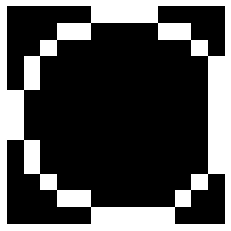

Dimensions: 13x13
Red Ratio: 0.31952662532824483
Blue Ratio: 0.01183431945660166
White+Black Ratio: 0.21301775021882988
Red Blue Ratio: 26.99998650000675
Detected circle
                 circle  quadrilateral   octagon  triangle
circularity    0.969999       0.697836  0.897422  0.434745
circle_extent  0.986774       0.695767  0.928570  0.388890
extent         0.871868       0.779000  0.943318  0.405816
min_extent     0.747739       0.678301  0.733529  0.840431
color_ratio    0.975253       0.595051  0.581178  0.848519
corners        1.000000       0.500000  1.000000  0.000000
AVG(P)         0.925272       0.657659  0.847336  0.486400


<Figure size 432x288 with 0 Axes>

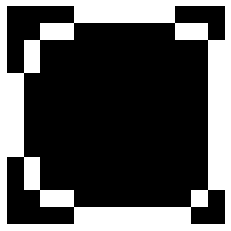

Shape detection for blue RoI
Dimensions: 41x23
Red Ratio: 0.001060445385938022
Blue Ratio: 0.5896076345815402
White+Black Ratio: 0.006362672315628131
Red Blue Ratio: 0.0017985611478443144
Detected quadrilateral
                 circle  quadrilateral   octagon  triangle
circularity    0.598972       0.881746  0.674378  0.844905
circle_extent  0.578895       0.804310  0.639006  0.977790
extent         0.901378       0.585275  0.836687  0.676661
min_extent     0.747678       0.676370  0.733085  0.842867
color_ratio    0.991340       0.991340  0.508661  0.508661
corners        0.400000       0.625000  0.400000  0.208333
AVG(P)         0.703044       0.760673  0.631969  0.676536


<Figure size 432x288 with 0 Axes>

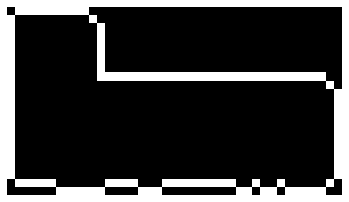

Dimensions: 41x23
Red Ratio: 0.002120890771876044
Blue Ratio: 0.5896076345815402
White+Black Ratio: 0.007423117701566153
Red Blue Ratio: 0.003597122295688629
Detected quadrilateral
                 circle  quadrilateral   octagon  triangle
circularity    0.600132       0.886222  0.676423  0.837224
circle_extent  0.578118       0.801310  0.637636  0.982937
extent         0.923846       0.590049  0.855534  0.630573
min_extent     0.747677       0.676311  0.733071  0.842942
color_ratio    0.991340       0.991340  0.508661  0.508661
corners        0.400000       0.625000  0.400000  0.208333
AVG(P)         0.706852       0.761705  0.635221  0.668445


<Figure size 432x288 with 0 Axes>

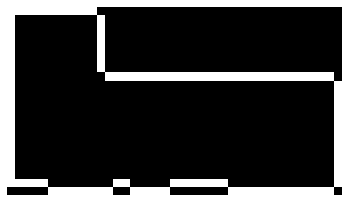

<Figure size 432x288 with 0 Axes>

In [32]:
# Mathematical ratios
circularity_ratios = {
    "circle": 1,
    "quadrilateral": 0.70,
    "octagon": 0.92,
    "triangle": 0.41,
    # "diamond": 0.64,
}

extent_ratios = {
    "circle": 0.785,
    "quadrilateral": 1,
    "octagon": 0.829,
    "triangle": 0.498,
    # "diamond": 0.5,
}

minextent_ratios = {
    "circle": 0.785,
    "quadrilateral": 1,
    "octagon": 0.829,
    "triangle": 0.498,
    # "diamond": 1
}

red_ratios = {
    "circle": 0.30,
    "quadrilateral": 0.0,
    "octagon": 0.65,
    "triangle": 0.20,
}

blue_ratios = {
    "circle": 0.60,
    "quadrilateral": 0.60,
    "octagon": 0.0,
    "triangle": 0.0,
}

output_classes = defaultdict(lambda: "unknown", {
    ("circle", "red"): "prohibitory",
    ("triangle", "red"): "priority",
    ("octagon", "red"): "stop",

    ("quadrilateral", "blue"): "information",
    ("circle", "blue"): "mandatory",
})

def detect_shape(roi, roi_type, return_probabilities = False):
    (brect_x, brect_y, brect_w, brect_h), contour, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea, sqp, trg, circle = roi

    contourPerimeter = cv.arcLength(contour, True)
    # Bounding Rectangle Area - used to calculate extent of contour
    brect_area = brect_w * brect_h
    extent = contourArea / (brect_area + 1e-6)

    # Minimum Bounding Rectangle - takes into account orientation and fits the bounding rectangle thighly
    (min_brect_x0, min_brect_y0), (min_brect_x1, min_brect_y1), min_brect_angle = cv.minAreaRect(contour)
    min_brect_area = abs(min_brect_x0 - min_brect_x1) * abs(min_brect_y0 - min_brect_y1)

    min_extent = contourArea / (min_brect_area + 1e-6)

    # Circularity - measures how compact the contour is
    circularity = (4 * np.pi * contourArea) / (contourPerimeter * contourPerimeter + 1e-6)

    # Minimum Enclosing Circle - similar to circularity
    (min_circle_x, min_circle_y), circle_radius = cv.minEnclosingCircle(contour)
    min_circle_area = np.pi * circle_radius * circle_radius

    circle_extent = contourArea / (min_circle_area + 1e-6)

    metrics = ["circularity", "circle_extent", "extent", "min_extent"]
    ratios = [circularity, circle_extent, extent, min_extent]
    ratio_tables = [circularity_ratios, circularity_ratios, extent_ratios, minextent_ratios]
    if roi_type == "red":
        metrics.append("color_ratio")
        ratios.append(red_ratio)
        ratio_tables.append(red_ratios)
    elif roi_type == "blue":
        metrics.append("color_ratio")
        ratios.append(blue_ratio)
        ratio_tables.append(blue_ratios)
    
    metrics.append("corners")
    n_metrics = len(metrics)

    classes = ["circle", "quadrilateral", "octagon", "triangle"] # Add diamond
    n_classes = len(classes)

    probability_table = np.zeros(shape=(n_metrics + 1, n_classes + 1))
    for i in range(n_metrics - 1):
        ratio = ratios[i]
        table = ratio_tables[i]
        for j in range(n_classes):
            shape_class = classes[j]
            class_ratio = table[shape_class]
            probability_table[i, j] = abs(ratio - class_ratio) # / (class_ratio + 1e-6)
        
        probability_table[i, n_classes] = np.sum(probability_table[i, 0:n_classes])
        probability_table[i, 0:n_classes] = (1 - (probability_table[i, 0:n_classes] / (probability_table[i, n_classes] + 1e-6))) #/ (n_classes - 1)
        probability_table[i, n_classes] = np.sum(probability_table[i, 0:n_classes])

    # Add corners row
    probability_table[n_metrics - 1, :n_classes] = np.array([circle, sqp, circle, trg])
    # probability_table[n_metrics - 1, n_classes] = np.sum(probability_table[n_metrics - 1, 0:n_classes])
    # probability_table[n_metrics - 1, :n_classes] /= (probability_table[n_metrics - 1, n_classes] + 1e-6)

    probability_table[-1, :n_classes] = np.mean(probability_table[:-1, :-1], axis=0)
    probability_table[-1, n_classes] = np.sum(probability_table[-1, 0:n_classes])

    CORNER_THRESHOLD = 0.55

    if roi_type == "red":
        max_corner = np.argmax(probability_table[metrics.index("corners"), :n_classes])
        corner_prob = probability_table[metrics.index("corners"), max_corner]
        if corner_prob < 0.40:
            circularity = np.max([
                    probability_table[metrics.index("circularity"), 0],
                    probability_table[metrics.index("circle_extent"), 0]
                ])
            if circularity > 0.90:
                color_ratio = np.array([probability_table[metrics.index("color_ratio"), 0], probability_table[metrics.index("color_ratio"), 2]])
                max_color_ratio = np.argmax(color_ratio)
                max_color_ratio_prob = color_ratio[max_color_ratio]
                if max_color_ratio == 1 and max_color_ratio_prob > 0.8:
                    chosen_shape = "octagon"
                elif max_color_ratio == 0 and max_color_ratio_prob > 0.8:
                    chosen_shape = "circle"
                else:
                    chosen_shape = "other"
            else:
                chosen_shape = "other"
        else:
            if max_corner == 1: # quadrilateral
                chosen_shape = "other"
            elif (max_corner == 0 or max_corner == 2) and corner_prob > CORNER_THRESHOLD: # circle | octagon
                color_ratio = np.array([probability_table[metrics.index("color_ratio"), 0], probability_table[metrics.index("color_ratio"), 2]])
                max_color_ratio = np.argmax(color_ratio)
                max_color_ratio_prob = color_ratio[max_color_ratio]
                if max_color_ratio == 1 and max_color_ratio_prob > 0.8:
                    chosen_shape = "octagon"
                elif max_color_ratio == 0 and max_color_ratio_prob > 0.8:
                    chosen_shape = "circle"
                else:
                    circularity = np.mean(np.vstack([
                        probability_table[metrics.index("circularity"), :n_classes],
                        probability_table[metrics.index("circle_extent"), :n_classes]
                        ]), axis=0
                    )
                    max_circularity = np.argmax(circularity)
                    max_circularity_prob = circularity[max_circularity]

                    if max_circularity_prob > 0.8:
                        if max_circularity == 0:
                            chosen_shape = "circle"
                        elif max_circularity == 2:
                            chosen_shape = "octagon"
                        else:
                            chosen_shape = "other"
                    else:
                        chosen_shape = "other"
            elif corner_prob > CORNER_THRESHOLD: # triangle
                max_color_ratio = np.argmax(probability_table[metrics.index("color_ratio"), :n_classes])
                if max_color_ratio == 0 or max_color_ratio == 3: # circle | triangle
                    max_circle_extent = np.argmax(probability_table[metrics.index("circle_extent"), :n_classes])
                    if max_circle_extent == 0 or max_circle_extent == 2:
                        chosen_shape = "other"
                    else:
                        chosen_shape = "triangle"
                else:
                    chosen_shape = "other"
            else:
                chosen_shape = "other"

    elif roi_type == "blue":
        max_color_ratio = np.argmax(probability_table[metrics.index("color_ratio"), :n_classes])
        if max_color_ratio == 0 or max_color_ratio == 1: # circle | quadrilateral
            max_corner = np.argmax(probability_table[metrics.index("corners"), :n_classes])
            corner_prob = probability_table[metrics.index("corners"), max_corner]
            if corner_prob < 0.40:
                circularity = np.max([
                        probability_table[metrics.index("circularity"), 0],
                        probability_table[metrics.index("circle_extent"), 0]
                    ])
                if circularity > 0.90:
                    chosen_shape = "circle"
                else:
                    chosen_shape = "other"
            else:
                if (max_corner == 0 or max_corner == 2) and corner_prob > CORNER_THRESHOLD: # circle | octagon
                    circularity = np.mean(np.vstack([
                        probability_table[metrics.index("circularity"), :n_classes],
                        probability_table[metrics.index("circle_extent"), :n_classes]
                        ]), axis=0
                    )
                    max_circularity = np.argmax(circularity)

                    if max_circularity == 0 or max_circularity == 2:
                        chosen_shape = "circle"
                    else:
                        chosen_shape = "other"

                elif max_corner == 1 and corner_prob > CORNER_THRESHOLD: # quadrilateral
                    avg_prob = np.mean(probability_table[:-1, :-1], axis=0)
                    quad_avg_prob = avg_prob[classes.index("quadrilateral")]
                    if quad_avg_prob > 0.7:
                        chosen_shape = "quadrilateral"
                    else:
                        chosen_shape = "other"
                elif corner_prob > CORNER_THRESHOLD: # triangle
                    avg_prob = np.mean(probability_table[:-1, :-1], axis=0)
                    max_avg_prob = np.argmax(avg_prob)
                    if max_avg_prob != 1:
                        chosen_shape = "other"
                    else: 
                        quad_avg_prob = avg_prob[classes.index("quadrilateral")]
                        if quad_avg_prob > 0.7:
                            chosen_shape = "quadrilateral"
                        else:
                            chosen_shape = "other"
                else:
                    chosen_shape = "other"
        else:
            chosen_shape = "other"

    if return_probabilities:
        df = pd.DataFrame(data=probability_table[:, :-1], columns=classes, index=metrics + ["AVG(P)"])
        return chosen_shape, df

    return chosen_shape

output_image = src_image.copy()
print("Shape detection for red RoI")
for roi in red_roi:
    shape, prob_table = detect_shape(roi, "red", return_probabilities=True)

    (x, y, w, h), contours, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea, sqp, trg, circle = roi
    region = np.zeros_like(red_edges[y:y+h, x:x+w])
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))

    print(f"Dimensions: {w}x{h}")
    print(f"Red Ratio: {red_ratio}")
    print(f"Blue Ratio: {blue_ratio}")
    print(f"White+Black Ratio: {white_black_ratio}")
    print(f"Red Blue Ratio: {red_blue_ratio}")
    print(f"Detected {shape}")
    print(prob_table)
    fig, ax = display_gray_image(region)
    plt.clf();

    # Draw output
    if shape != "other":
        cv.drawContours(output_image, [contours], 0, color=(25, 255, 40), thickness=2)
        output_class = output_classes[(shape, "red")]
        cv.putText(output_image, output_class, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (25, 255, 40), 2, cv.LINE_AA)

print("Shape detection for blue RoI")
for roi in blue_roi:
    shape, prob_table = detect_shape(roi, "blue", return_probabilities=True)

    (x, y, w, h), contours, red_ratio, blue_ratio, white_black_ratio, red_blue_ratio, contourArea, sqp, trg, circle = roi
    region = np.zeros_like(blue_edges[y:y+h, x:x+w])
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))

    print(f"Dimensions: {w}x{h}")
    print(f"Red Ratio: {red_ratio}")
    print(f"Blue Ratio: {blue_ratio}")
    print(f"White+Black Ratio: {white_black_ratio}")
    print(f"Red Blue Ratio: {red_blue_ratio}")
    print(f"Detected {shape}")
    print(prob_table)
    fig, ax = display_gray_image(region)
    plt.clf();

    # Draw output
    if shape != "other":
        cv.drawContours(output_image, [contours], 0, color=(25, 255, 40), thickness=2)
        output_class = output_classes[(shape, "blue")]
        cv.putText(output_image, output_class, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (25, 255, 40), 2, cv.LINE_AA)

# Output

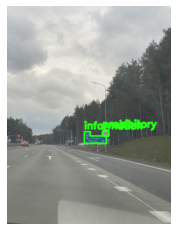

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [33]:
display_bgr_image(output_image)